In [1]:
import albumentations as A
import os
from tensorflow.keras.utils import load_img, img_to_array
import scipy.ndimage as nd
from scipy.ndimage import gaussian_filter
from torch_geometric.data import Dataset 
import numpy as np
from skimage.filters import threshold_otsu, gaussian
from skimage.transform import resize
from skimage.morphology import skeletonize, binary_dilation
import networkx as nx
import cv2
from torch_geometric.data import Data
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Augmentaties definiëren

In [2]:
def resize_with_padding(img, target_size=64, inner_size=60):
    """
    Resize afbeelding proportioneel zodat het in 'inner_size' past
    en vul aan met padding tot 'target_size' x 'target_size'.
    """
    h, w = img.shape
    scale = min(inner_size / h, inner_size / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = resize(img, (new_h, new_w), mode='constant', anti_aliasing=True)
    pad_h = target_size - new_h
    pad_w = target_size - new_w
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    return np.pad(resized, ((top, bottom), (left, right)), mode='constant', constant_values=0)

def preprocess_image(img, target_size=64, inner_size=60):
    """
    Preprocess een grijswaarde-afbeelding tot een skeleton:
    normalisatie, Otsu-binarisatie, crop, resize, smooth, skeletonize.
    """
    img = img / 255.0 if img.max() > 1 else img
    threshold = threshold_otsu(img)
    binary = img > threshold

    rows, cols = np.any(binary, axis=1), np.any(binary, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    margin = 1
    rmin = max(rmin - margin, 0)
    rmax = min(rmax + margin, img.shape[0] - 1)
    cmin = max(cmin - margin, 0)
    cmax = min(cmax + margin, img.shape[1] - 1)
    cropped = img[rmin:rmax+1, cmin:cmax+1]

    resized = resize_with_padding(cropped, target_size, inner_size)
    smoothed = gaussian(resized, sigma=1.0)
    binary = smoothed > threshold_otsu(smoothed)

    skeleton1 = skeletonize(binary)
    dilated = binary_dilation(skeleton1)
    skeleton = skeletonize(dilated)
    return skeleton

def skeleton_to_graph(skeleton):
    """
    Zet een skeleton afbeelding om naar een graf waarbij pixels knopen zijn
    en randen tussen naburige skeletpunten worden gelegd.
    """
    coords = np.argwhere(skeleton)
    G = nx.Graph()
    for y, x in coords:
        G.add_node((x, y))
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                ny, nx_ = y + dy, x + dx
                if 0 <= ny < skeleton.shape[0] and 0 <= nx_ < skeleton.shape[1]:
                    if skeleton[ny, nx_]:
                        G.add_edge((x, y), (nx_, ny))
    return G

def project_graph_to_grid(G, grid_size=8, image_size=64):
    """
    Projecteer een graf op een raster van formaat grid_size x grid_size.
    Elke knoop wordt gemapt naar een cel en randen tussen cellen worden toegevoegd.
    """
    cell_size = image_size // grid_size
    G_projected = nx.Graph()
    point_to_cell = {}
    added_edges = set()

    for x, y in G.nodes:
        cx = int(x / cell_size)
        cy = int(y / cell_size)
        cell = (cx, cy)
        point_to_cell[(x, y)] = cell
        G_projected.add_node(cell)

    for u, v in G.edges:
        cu = point_to_cell.get(u)
        cv = point_to_cell.get(v)
        if cu and cv and cu != cv:
            edge = tuple(sorted((cu, cv)))
            if edge not in added_edges:
                G_projected.add_edge(*edge)
                added_edges.add(edge)

    return G_projected


def graph_to_pyg_data(G, grid_size=8, label=None):
    """
    Zet een graf om naar een PyTorch Geometric 'Data' object
    met one-hot node features, bidirectionele randen en optioneel een label.
    """
    num_nodes = grid_size * grid_size
    node_index_map = { (x, y): y * grid_size + x for x in range(grid_size) for y in range(grid_size) }

    features = []
    for y in range(grid_size):
         for x in range(grid_size):
            idx = y * grid_size + x
            one_hot = torch.zeros(num_nodes)
            one_hot[idx] = 1.0
            features.append(one_hot)

    x = torch.stack(features) 

    edge_index = []
    for (u, v) in G.edges:
        uid = node_index_map.get(u)
        vid = node_index_map.get(v)
        if uid is not None and vid is not None:
            edge_index.append([uid, vid])
            edge_index.append([vid, uid])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    data = Data(x=x, edge_index=edge_index)

    if label is not None:
        data.y = torch.tensor([label], dtype=torch.long)

    return data


class PyGSkeletonDataset(Dataset):
    """
    Dataset-klasse die afbeeldingen omzet in geskeletoniseerde grafen,
    geprojecteerd op een rooster, klaar voor gebruik in PyTorch Geometric.
    """
    def __init__(self, images, labels=None, grid_size=8):
        """
        Initialiseert de dataset door elke afbeelding om te zetten in een PyG graf.
        
        Args:
            images (list or array): Lijst van grijswaarde-afbeeldingen.
            labels (list or array, optional): Optionele labels per afbeelding.
            grid_size (int): Grootte van het raster (bijv. 8 voor 8x8).
        """
        self.images = images
        self.labels = labels
        self.grid_size = grid_size
        self.graphs = [self._image_to_graph(img, i) for i, img in enumerate(images)]

    def _image_to_graph(self, img, idx):
        """
        Zet één afbeelding om naar een geskeletoniseerde, gerasterde graf.
        
        Args:
            img (np.ndarray): Grijswaarde-afbeelding.
            idx (int): Index van de afbeelding, gebruikt om het juiste label te vinden.
        
        Returns:
            torch_geometric.data.Data: Graph-representatie van de afbeelding.
        """
        skeleton = preprocess_image(img)
        G = skeleton_to_graph(skeleton)
        G_proj = project_graph_to_grid(G, grid_size=self.grid_size)
        label = self.labels[idx] if self.labels is not None else None
        return graph_to_pyg_data(G_proj, grid_size=self.grid_size, label=label)

    def __len__(self):
        """
        Geeft het aantal grafen in de dataset.
        """
        return len(self.graphs)

    def __getitem__(self, idx):
        """
        Haalt één PyG graf op uit de dataset.
        
        Args:
            idx (int): Index van het gewenste datapunt.
        
        Returns:
            torch_geometric.data.Data: De graf op positie idx.
        """
        return self.graphs[idx]
    

def edge_index_to_image(edge_index, image_size=64, grid_size=8, line_thickness=3):
    """
    Zet een edge_index om naar een binair beeld (float32, 0-1) door lijnen te tekenen
    tussen de knopen van een 8x8 grid. Output is shape (64, 64) in float.
    """
    # Leeg canvas
    img = np.zeros((image_size, image_size), dtype=np.uint8)

    # Celgrootte en coördinaten berekenen
    cell_size = image_size // grid_size
    positions = {
        i: (int((i % grid_size + 0.5) * cell_size),
            int((i // grid_size + 0.5) * cell_size))
        for i in range(grid_size * grid_size)
    }

    # Lijnen tekenen
    for u, v in edge_index.t().tolist():
        pt1 = positions[u]
        pt2 = positions[v]
        cv2.line(img, pt1, pt2, color=255, thickness=line_thickness)

    # Schalen naar float32 in [0, 1]
    img = img.astype(np.float32) / 255.0

    return img

In [3]:
def voeg_rafelruis_toe(img, ruis_std=0.02, drempel=0.6):
    if img.max() > 1.0:
        img = img / 255.0
    if img.ndim == 3:
        img = img.mean(axis=-1)
    binair = (img > drempel).astype(np.float32)
    dx = nd.sobel(binair, axis=0)
    dy = nd.sobel(binair, axis=1)
    rand = np.hypot(dx, dy)
    jitter = np.random.normal(loc=0.0, scale=ruis_std, size=img.shape)
    jitter = gaussian_filter(jitter, sigma=0.3)
    masker = (rand > 0.1) & (np.random.rand(*img.shape) < 0.3)
    img = img + (jitter * masker)
    img = np.clip(img, 0.0, 1.0)
    binair = (img > drempel).astype(np.float32)
    return np.expand_dims(binair, axis=-1)

# Albumentations pipelines
strong_albu = A.Compose([
    A.LongestMaxSize(128),
    A.Rotate(limit=10),
    A.Affine(scale=(0.85, 1.15)),
    A.Affine(shear={"x": (-10, 10), "y": (-10, 10)}),
    A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0, rotate_limit=0),
    A.OneOf([
        A.Perspective(scale=(0.05, 0.1), keep_size=True, p=1),
        A.ElasticTransform(alpha=10, sigma=2, alpha_affine=2, p=1)
    ], p=0.5),
    A.Resize(64, 64)
])

weak_albu = A.Compose([
    A.LongestMaxSize(128),
    A.Rotate(limit=5),
    A.Affine(scale=(0.95, 1.05)),
    A.Affine(shear={"x": (-5, 5), "y": (-5, 5)}),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0, rotate_limit=0),
    A.Perspective(scale=(0.05, 0.1), keep_size=True, p=0.5),
    A.Resize(64, 64)
])


c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\lenka\AppData\Local\Temp\ipykernel_17348\4067495762.py:27: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=10, sigma=2, alpha_affine=2, p=1)


# Dataset inladen

In [4]:
def load_dataset(dataset_dir):
    X, y = [], []
    label_map = {str(i): i for i in range(10)}
    for label_str in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label_str)
        if not os.path.isdir(label_path):
            continue
        for fname in os.listdir(label_path):
            img_path = os.path.join(label_path, fname)
            img = load_img(img_path, color_mode='grayscale', target_size=(64, 64))
            X.append(img_to_array(img) / 255.0)
            y.append(label_map[label_str])
    return np.array(X), np.array(y)

X_test, y_test = load_dataset("synthetic_digits/test")


# Augmentatie aan testset toevoegen

In [5]:
X_augmented = []
y_augmented = []

for img, label in zip(X_test, y_test):
    # Sterk pad
    img_strong = strong_albu(image=img.astype(np.float32))['image']
    img_strong = voeg_rafelruis_toe(img_strong)
    X_augmented.append(img_strong)
    y_augmented.append(label)

    # Zwak → skeleton → graaf
    img_weak = weak_albu(image=img.astype(np.float32))['image']
    skeleton = preprocess_image(img_weak.squeeze())
    G = skeleton_to_graph(skeleton)
    G_proj = project_graph_to_grid(G, grid_size=8)

    node_index_map = {(x, y): y * 8 + x for x in range(8) for y in range(8)}
    edge_index = []
    for u, v in G_proj.edges:
        uid = node_index_map.get(u)
        vid = node_index_map.get(v)
        if uid is not None and vid is not None:
            edge_index.append([uid, vid])
            edge_index.append([vid, uid])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    binary_img = edge_index_to_image(edge_index)
    binary_img = np.expand_dims(binary_img, axis=-1).astype(np.float32)

    X_augmented.append(binary_img)
    y_augmented.append(label)

# Zet naar arrays
X_test_augmented = np.stack(X_augmented)
y_test_augmented = np.array(y_augmented)


# Model inladen

In [6]:
from tensorflow.keras.models import load_model

model = load_model("models/final_model_full_train.keras")


# Voorspelling uitvoeren op testset

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test Accuracy (met originele en graafbeelden): 0.9935
Classification Report:
              precision    recall  f1-score   support

           0     0.9787    1.0000    0.9892        46
           1     0.9787    1.0000    0.9892        46
           2     1.0000    1.0000    1.0000        46
           3     1.0000    1.0000    1.0000        46
           4     1.0000    1.0000    1.0000        46
           5     1.0000    1.0000    1.0000        46
           6     1.0000    0.9783    0.9890        46
           7     1.0000    0.9783    0.9890        46
           8     0.9787    1.0000    0.9892        46
           9     1.0000    0.9783    0.9890        46

    accuracy                         0.9935       460
   macro avg     0.9936    0.9935    0.9935       460
weighted avg     0.9936    0.9935    0.9935       460



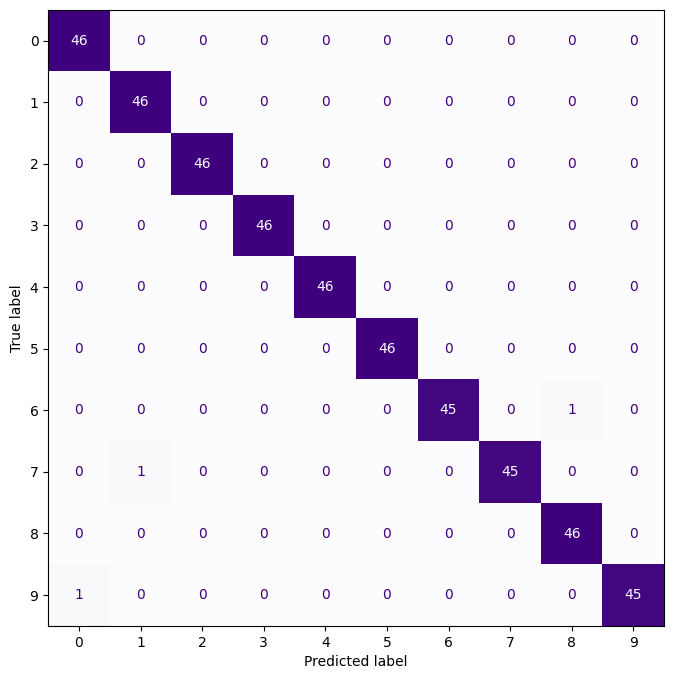

In [ ]:
# Normaliseer
if X_test_augmented.max() > 1:
    X_test_augmented = X_test_augmented / 255.0

# Voorspellen
y_probs = model.predict(X_test_augmented)
y_pred = np.argmax(y_probs, axis=1)

# Evaluatie
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

print(f"Test Accuracy (met originele en graafbeelden): {accuracy_score(y_test_augmented, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test_augmented, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test_augmented, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Purples', colorbar=False)
plt.show()


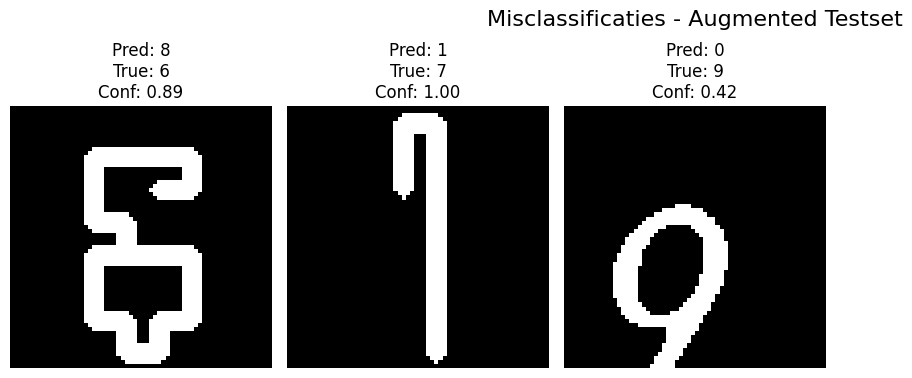

In [ ]:
# Clean y-labels (voor het geval one-hot gebruikt is)
y_clean = np.argmax(y_test_augmented, axis=1) if y_test_augmented.ndim > 1 else y_test_augmented

# Vind indexen waar fouten zijn
misclassified_idxs = np.where(y_pred != y_clean)[0]
num_to_show = min(10, len(misclassified_idxs))
plt.figure(figsize=(14, 8))
for i, idx in enumerate(misclassified_idxs[:num_to_show]):
    plt.subplot(2, 5, i + 1)
    image = X_test_augmented[idx]

    if image.ndim == 3 and image.shape[-1] == 1:
        image = image.squeeze(-1)
    elif image.ndim == 3 and image.shape[-1] == 3:
        image = image / 255.0

    confidence = np.max(y_probs[idx])
    plt.imshow(image, cmap='gray')
    plt.title(f"Pred: {y_pred[idx]}\nTrue: {y_clean[idx]}\nConf: {confidence:.2f}")
    plt.axis('off')

plt.suptitle("Misclassificaties - Augmented Testset", fontsize=16)
plt.tight_layout()
plt.show()
